### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 2: Filtrado de señales

## Introducción


Un **electrocardiograma (ECG)** es un gráfico de voltaje (amplitud) en función del tiempo correspondiente a la actividad eléctrica del corazón. Cada etapa del ciclo cardíaco es representado por una letra: **P, Q, R, S y T**. La siguiente figura muestra un esquema de un ECG con dos pulsos.

<img src="cardio.png" width="600">


El ECG se usa para hacer diagnósticos y en particular para analizar la existencia de anormalidades en el ciclo cardiaco. La **frecuencia cardiaca**, es decir el inverso del intervalo RR, de un humano normal en reposo está en el rango de **60 y 100 latidos por minuto**



## Enunciado

El hospital base de Valdivia tiene un electrocardiógrafo que mide la ECG en miliVolts [mV] a una frecuencia de muestreo de $360$ [Hz]

Durante el proceso de captura ciertos errores provocaron que la señal se contamine con 

- **(A)** Un ruido asociado al sistema eléctrico
- **(B)** Un ruido de baja frecuencia causado por un desperfecto del sensor
- **(C)** Un ruido blanco de origen térmico 

Esto complica el análisis del médico por lo que el hospital base los contrata a ustedes para **diseñar un filtro que limpie la señal ECG**

Resuelva las actividades que se piden a continuación, respondiendo y analizando donde corresponda

<IPython.core.display.Javascript object>


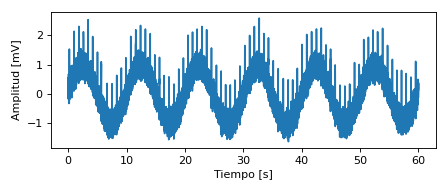

In [14]:
import numpy as np
import pickle
%matplotlib notebook
import matplotlib.pylab as plt

with open("ECG.pkl", "rb") as f:
    data = pickle.load(f)

Fs = 360
time = np.arange(len(data))/Fs
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud [mV]');

In [15]:
from IPython.display import Audio
Audio(data, rate=Fs)

## Análisis (15%)

- Observe los primeros dos segundos de la señal, compare con el esquema mostrado en la introducción y discuta sobre los efectos causados por los ruidos **A**, **B** y **C** mencionados en el enunciado. Además responda  ¿Qué es un ruido blanco y que tipo de efecto introduce en la señal y en su espectro? ¿Qué es una tendencia y que tipo de efecto introduce en la señal y su espectro? 
- Calcule y muestre gráficamente el valor absoluto de la transformada de Fourier de la señal en función de la frecuencia y su espectrograma en función del tiempo y la frecuencia. Para el espectrograma decida el largo de ventana, traslape y tipo de ventana. Justifique su elección tomando en consideración el rango de frecuencias de un paciente normal y los *trade-off* aprendidos en clases
- En base a la señal, su espectro de magnitud y su espectrograma identifique la frecuencia central o el rango de frecuencias asociada a las tres fuentes de ruido. ¿En qué rango de frecuencias (Hz) se espera encontrar la señal de ritmo cardíaco de un humano normal en reposo?


   **Primeros 2 segundos de la señal.**

<IPython.core.display.Javascript object>


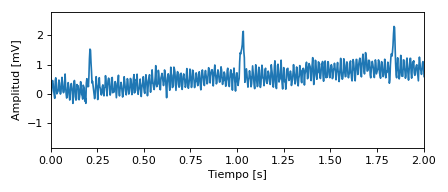

In [49]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time, data)
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud [mV]')
#Muestra los primeros 2 segundos
ax.set_xlim(0,2);


En esta señal podemos apreciar los primeros 2 segundos del ECG, donde se puede apreciar ruido rojo, debido a que se puede ver una ligera tendencia.

Comparando estos 2 segundos con el gráfico inicial se aprecia que en realidad la señal que buscamos está sobre otra señal, que varía un poco más lento y de tipo sinusoidal.

El ruido **A** debería ser fácil de detectar ya que se vería de forma más clara en el espectrograma, contribuye a la pérdida de la señal.

El ruido **B** debería encontrarse el sector inferior del espectrograma ya que son los valores que de frecuencia bajos,este es el responsable que la señal tenga un tendencia sinusoidal en vez de recta, como debería verse un ECG.

El ruido **C** afectaría en todo el espectro ya que dejaría marcas por todas partes y provocaría que no se escuche de forma clara.



**Ruido Blanco:**

Este tipo de ruido está caracterizado por ser una señal aleatoria y no posee ninguna correlación estadística, esto provoca que se pierda información en el ruido ya que algunas señales se verían opacadas por los picos del ruido , además de ser más complicado de corregir.


**Tendencia:**

Hace referencia al comportamiento de la señal, se puede apreciar que la señal va creciendo el los primeros 3 segundos.


In [50]:
import scipy.fft as sfft
import scipy.signal;

<IPython.core.display.Javascript object>


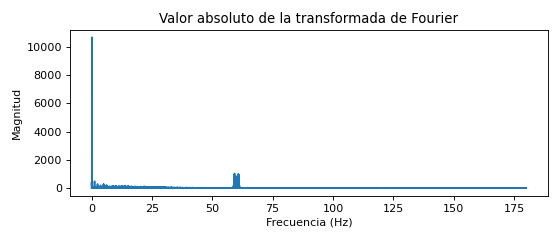

In [51]:
freqs = sfft.rfftfreq(n=len(data),d=1./Fs)
S = np.absolute(sfft.rfft(data))
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(freqs, S)
ax.set_xlabel('Frecuencia (Hz)')
ax.set_ylabel('Magnitud')
ax.set_title("Valor absoluto de la transformada de Fourier");

<IPython.core.display.Javascript object>


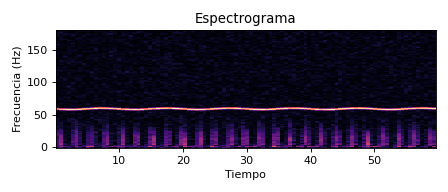

In [52]:
freqs, times, Sxx = scipy.signal.spectrogram(data,fs=Fs,window=('kaiser',5),nperseg=250, mode = 'magnitude')
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.pcolormesh(times,freqs,Sxx,cmap=plt.cm.magma,shading="auto")
ax.set_xlabel("Tiempo")
ax.set_ylabel("Frecuencia (Hz)")
ax.set_title("Espectrograma");

Se eligió un beta igual a 5 por y de tipo "kaiser" debido la relación que tiene la señal con una sinusoidal

Tomando como ejemplo un ECG real, se buscaron los datos que tengan una mejor relación, obteniendo así los valores del tamaño y el traslape de la ventana.


## Filtrado FIR (50%)

Describa lo que es un filtro FIR, explique paso a paso el método de enventanado y describa los argumentos y el valor de retorno de la función `scipy.signal.firwin`. 

Luego use este método para diseñar y aplicar tres filtros sobre la señal de entrada. El primero debe filtrar el ruido **(A)**, el segundo el ruido **(B)** y el tercero el ruido **(C)**. Indique la(s) frecuencia(s) de corte y el tipo de filtro en cada caso. Justifique su elección en base a sus observaciones en el paso anterior.

Considere una ventana de Hamming y $1001$ coeficientes para el filtro

Por cada filtro:
- Muestre la respuesta al impulso y la respuesta en frecuencia resultantes
- Filtre la señal convolucionando con la respuesta al impulso
- Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada. En base a lo que observa y a los gráficos del punto anterior discuta sobre la efectividad del filtro

Finalmente
- Filtre la señal convolucionando con los tres filtros. Muestre el resultado graficamente. 
- Muestre un acercamiento de los primeros tres segundos de la señal filtrada, reconozca la fase R y márquela con una linea roja punteada.
- Cree una función que mida el tiempo RR en la señal filtrada. Grafique la frecuencia cardiaca en función del tiempo. ¿Se encuentra la persona en el rango sano o no?

________________________________________________________________________________________________________

**Filtro FIR(Finite Impulse Response):**
Es un tipo de filtro digital que si su entrada es un impulso la salida será un número limitado de términos no nulos.

**Metodo de Enventanado:**
El objetivo es diseñar la respuesta del impulso, se crea a partir de un requisito, el cual puede ser un filtrocomo el pasa bajo o pasa alto.
Para usarlo:
1. Especificar una respuesta en frecuencia ideal dependiendo de los requerimientos.
2. Usar la transformada de Fourier inversa para obtener la respuesta al impulso ideal
3. Truncar la respuesta al impulso ideal usando una ventana como hamming, kaiser, etc. 

**Argumentos de "scipy.signal.firwin":**

Esta función calcula los coeficientes de un filtro de respuesta de impulso finito. El filtro tendrá fase lineal; será Tipo I si "numtaps" es impar y Tipo II si "numtaps" es par.

1. numtaps: Es un "int" que indica el largo del filtro.
2. cutoff: Es un "float" hace referencia a la frecuencia de corte del filtro o  una matris de frecuencias de corte.
3. width: Es un "float" si no se indica, entonces se debe asumir que es el ancho aproximado de la región de transición (expresado en las mismas unidades que "fs") para su uso en el diseño del filtro Kaiser FIR.
4. window: Cadena o tupla de cadena y valores de parámetro, Se especifica laVentana deseada para usar.
5. pass_zero: Puede ser (True, False, 'bandpass', 'lowpass', 'highpass', 'bandstop').
6. scale: Es un "boolean",En verdadero lo qeu hace es escalar los coeficientes de modo que la respuesta de frecuencia sea exactamente la unidad a una determinada frecuencia.
7. nyq: "Obsoleto"... 
8. fs: Es la frecuencia de muestreo de la señal. Cada frecuencia en "cutoff" debe estar entre 0 y "fs/2". El valor predeterminado es 2.

**Retorna:**

h= ndarray Coeficientes de longitud del filtro FIR `numtaps`.




# Crearemos el Primer Filtro para el ruido (A)

In [93]:
numtaps=1001
FIR = scipy.signal.firwin(numtaps=numtaps,window='hamming',fs=Fs,pass_zero="bandstop",cutoff=[58,62])
freq,H = scipy.signal.freqz(b=FIR,fs=Fs);

<IPython.core.display.Javascript object>


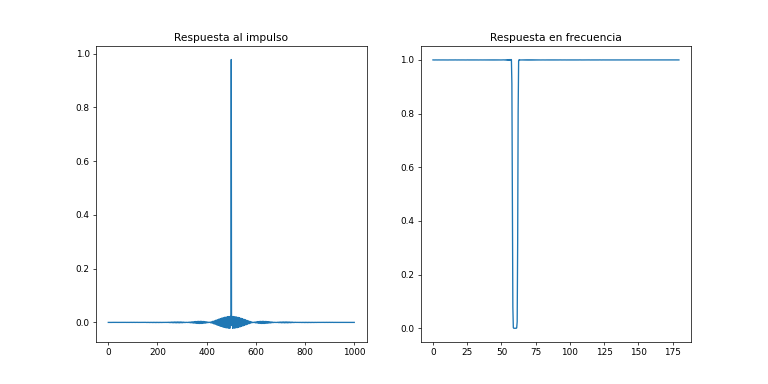

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
ax[0].set_title("Respuesta al impulso")
ax[1].set_title("Respuesta en frecuencia")
ax[0].plot(FIR)
ax[1].plot(freq,np.absolute(H));

In [95]:
#Filtre la señal convolucionando con la respuesta al impulso
beta = 5
nperseg = 250
Sin_A=scipy.signal.convolve(data,FIR,mode="same")
freq, times, Sxx = scipy.signal.spectrogram(Sin_A,fs=Fs,window=('kaiser',beta),nperseg=nperseg, mode = 'magnitude')

In [96]:
#Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? 
Resta_A=data-Sin_A
freqs = sfft.rfftfreq(n=len(Resta_A),d=1./Fs)
S = np.absolute(sfft.rfft(Resta_A))

Al restar la señal, en todos los filtros se debería observar claramente el sector de las frecuencias que ya no están. 

<IPython.core.display.Javascript object>


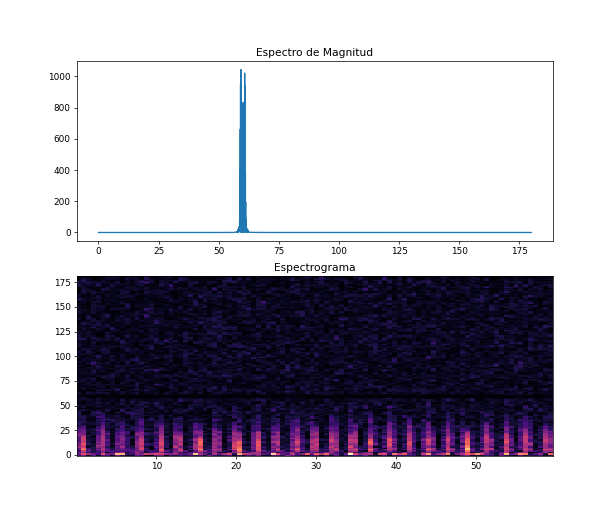

In [97]:
#Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada.
fig, ax = plt.subplots(2, 1, figsize=(12, 10), dpi=80)
ax[0].set_title("Espectro de Magnitud")
ax[1].set_title("Espectrograma")
ax[0].plot(freqs,S)
ax[1].pcolormesh(times,freq,Sxx,cmap=plt.cm.magma,shading="auto");

Se espera que sea muy efectivo, en teoría debería quitar de muy buena manera el ruido y no llevarse nada de información con él gracias a lo baja de las frecuencias de los latidos del corazón, y se puede apreciar esto de mejor manera en el espectrograma.

En el primer espectrograma se podia apreciar claramnete que los valores no deseados estaban en un rango de 
entre 50[Hz] y 70[Hz], se acotaron estos márgenes a 58[Hz] y 62[Hz] según lo analizado en 
el gráfico "Valor absoluto de la transformada de Fourier", ya que se pueden ver picos de datos en ese sector.

# Crearemos el Segundo Filtro para el ruido (B)

In [98]:
FIR_2 = scipy.signal.firwin(numtaps=numtaps,window='hamming',fs=Fs,pass_zero="highpass",cutoff=0.8)
freq,H = scipy.signal.freqz(b=FIR_2,fs=Fs);

<IPython.core.display.Javascript object>


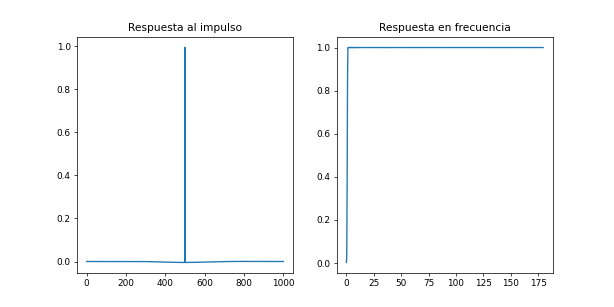

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
ax[0].set_title("Respuesta al impulso")
ax[1].set_title("Respuesta en frecuencia")
ax[0].plot(FIR_2)
ax[1].plot(freq,np.absolute(H));

In [100]:
#Filtre la señal convolucionando con la respuesta al impulso
Sin_B=scipy.signal.convolve(data,FIR_2,mode="same")
freq, times, Sxx = scipy.signal.spectrogram(Sin_B,fs=Fs,window=('kaiser',beta),nperseg=nperseg, mode = 'magnitude')

In [101]:
#Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? 
Resta_B=data-Sin_B
freqs = sfft.rfftfreq(n=len(Resta_B),d=1./Fs)
S = np.absolute(sfft.rfft(Resta_B))

Al restar la señal, en todos los filtros se debería observar claramente el sector de las frecuencias que ya no están.

<IPython.core.display.Javascript object>


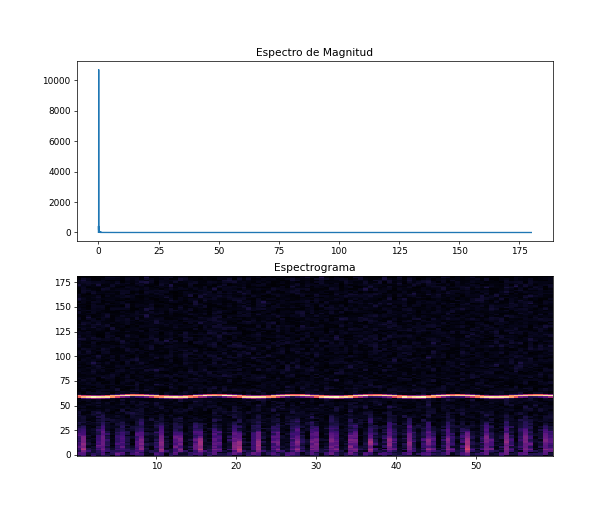

In [102]:
#Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada.
fig, ax = plt.subplots(2, 1, figsize=(12, 10), dpi=80)
ax[0].set_title("Espectro de Magnitud")
ax[1].set_title("Espectrograma")
ax[0].plot(freqs,S)
ax[1].pcolormesh(times,freq,Sxx,cmap=plt.cm.magma,shading="auto");
#En base a lo que observa y a los gráficos del punto anterior discuta sobre la efectividad del filtro

<IPython.core.display.Javascript object>


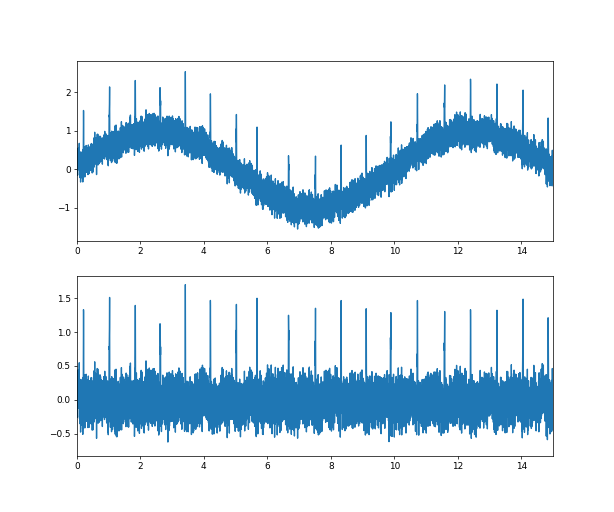

In [106]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), dpi=80)
ax[0].plot(time,data)
ax[1].plot(time,Sin_B)
ax[0].set_xlim(0,15)
ax[1].set_xlim(0,15);

También se puede observar un gran efecto del filtro, ya que elimina la tendencia sinusoidal, permitiendo apreciar de forma mucho más clara le ECG.

El ruido de baja frecuencia se encuentra en la parte más baja del espectrograma y al inicio del gráfico de "Valor absoluto de la transformada de Fourier", y además dura solo un instante, por lo que se eligió un valor de 0.8[Hz] para mantener la mayor cantidad de información importante.

# Crearemos el Tercer Filtro para el ruido (C)

In [64]:
FIR_3 = scipy.signal.firwin(numtaps=numtaps,window='hamming',fs=Fs,pass_zero="lowpass",cutoff=[40])
freq,H = scipy.signal.freqz(b=FIR_3,fs=Fs);

<IPython.core.display.Javascript object>


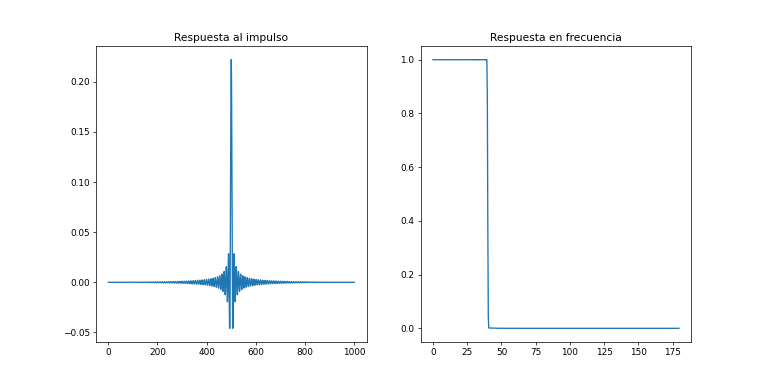

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=80)
ax[0].set_title("Respuesta al impulso")
ax[1].set_title("Respuesta en frecuencia")
ax[0].plot(FIR_3)
ax[1].plot(freq,np.absolute(H));

In [66]:
#Filtre la señal convolucionando con la respuesta al impulso
Sin_C=scipy.signal.convolve(data,FIR_3,mode="same")
freq, times, Sxx = scipy.signal.spectrogram(Sin_C,fs=Fs,window=('kaiser',beta),nperseg=nperseg, mode = 'magnitude')

In [67]:
#Calcule la resta entre la señal original y la señal filtrada. ¿Qué espera observar en este caso? 
Resta_C=data-Sin_C
freqs = sfft.rfftfreq(n=len(Resta_C),d=1./Fs)
S = np.absolute(sfft.rfft(Resta_C))

<IPython.core.display.Javascript object>


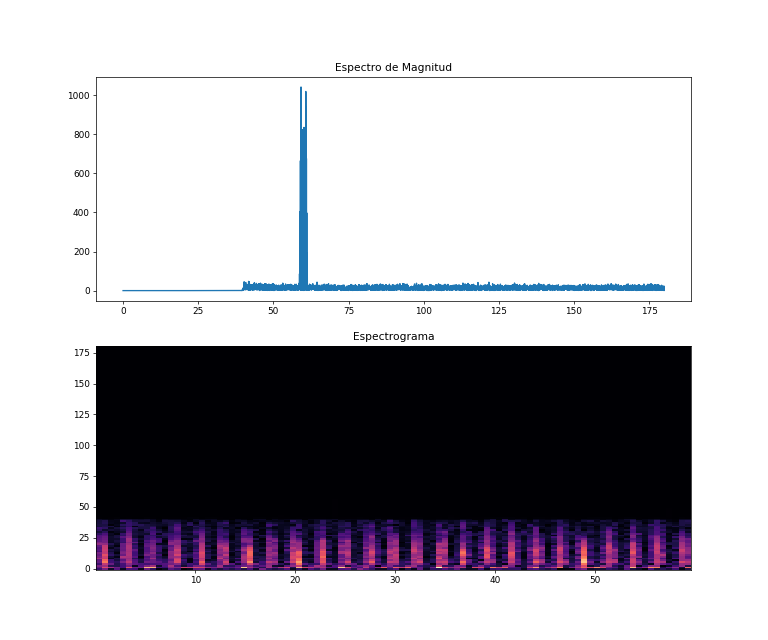

In [68]:
#Luego muestre gráficamente el espectro de magnitud y el espectrograma de la señal restada.
fig, ax = plt.subplots(2, 1, figsize=(12, 10), dpi=80)
ax[0].set_title("Espectro de Magnitud")
ax[1].set_title("Espectrograma")
ax[0].plot(freqs,S)
ax[1].pcolormesh(times,freq,Sxx,cmap=plt.cm.magma,shading="auto");
#En base a lo que observa y a los gráficos del punto anterior discuta sobre la efectividad del filtro

Este filtro podría ser uno de los que más problemas podría tener, ya que si se hace con frecuencias muy bajas se perdería información, por otro lado con frecuencias lo suficientemente altas , nos quedamos con demasiado ruido, usandolo de buena manera se podría obtener un buen filtro de ruido.

Para estos datos se usó el espectrograma, ya que en este caso es donde más perdido están los datos, es algo más parecido a la prueba y error, y es complicado evitar borrar datos que podrían importar, por lo que se optó por dejar un poco del ruido blanco , usando un lowpass y 40[Hz].Para estos datos se usó el espectrograma, ya que en este caso es donde más perdido están los datos, es algo más parecido a la prueba y error, y es complicado evitar borrar datos que podrían importar, por lo que se optó por dejar un poco del ruido blanco , usando un lowpass y 40[Hz].

# Convolucion de los 3 filtros

<IPython.core.display.Javascript object>


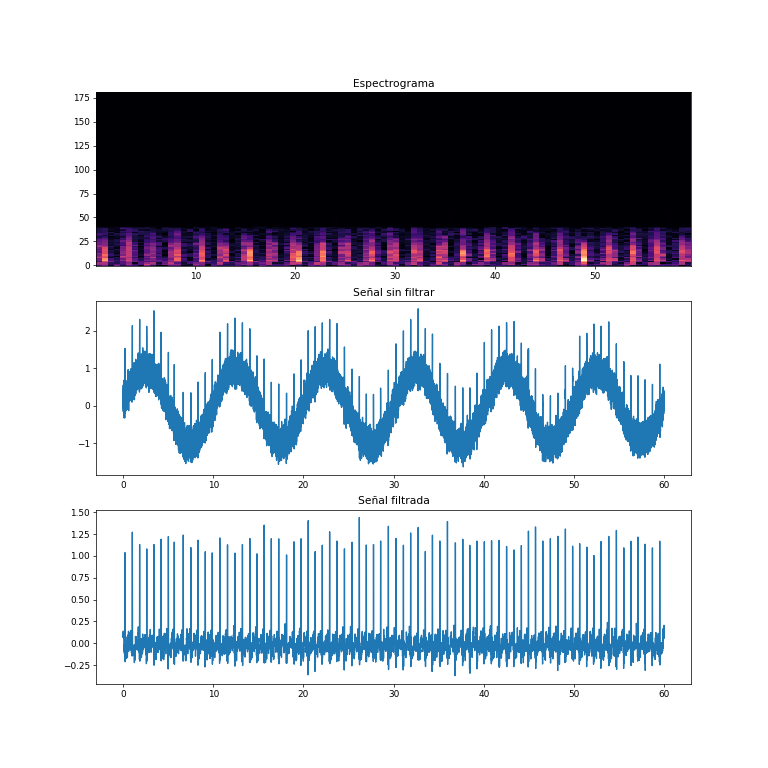

In [107]:
Señal_limpia=scipy.signal.convolve(data,FIR,mode="same")

Señal_limpia=scipy.signal.convolve(Señal_limpia,FIR_2,mode="same")

Señal_limpia=scipy.signal.convolve(Señal_limpia,FIR_3,mode="same")

#Volvemos a hacer el espectrograma
freqs, times, Sxx = scipy.signal.spectrogram(Señal_limpia,fs=Fs,window=('kaiser',beta),nperseg=nperseg,mode = 'magnitude')

fig, ax = plt.subplots(3, 1, figsize=(12, 12), dpi=80)
ax[0].pcolormesh(times,freqs,Sxx,cmap=plt.cm.magma,shading="auto")
ax[2].plot(time,Señal_limpia)
ax[1].plot(time,data)
ax[0].set_title("Espectrograma")
ax[1].set_title("Señal sin filtrar")
ax[2].set_title("Señal filtrada");

# Primeros 3 segundos de la señal filtrada.

<IPython.core.display.Javascript object>


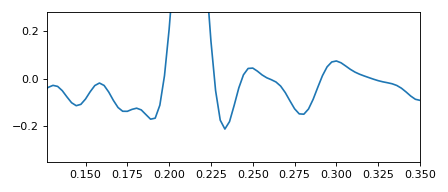

In [108]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time,Señal_limpia)
ax.set_xlim(0,3);

<IPython.core.display.Javascript object>


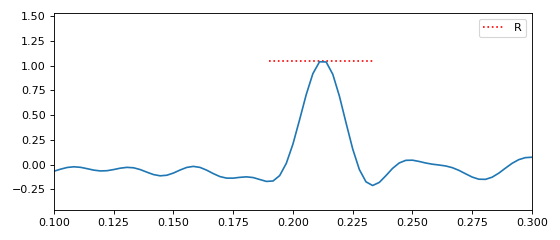

In [112]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time,Señal_limpia)
ax.hlines(y=1.041, xmin=0.19, xmax=0.2336,color='red', zorder=1, label= 'R',ls=':') 
ax.legend()
ax.set_xlim(0.1,0.3);

In [113]:
from IPython.display import Audio
Audio(Señal_limpia, rate=Fs)

* Cree una función que mida el tiempo RR en la señal filtrada. Grafique la frecuencia cardiaca en función del tiempo. ¿Se encuentra la persona en el rango sano o no?


<IPython.core.display.Javascript object>


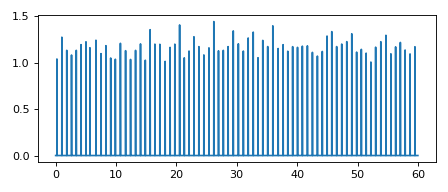

In [128]:
Señal_limpia2=Señal_limpia
for i in range(len(Señal_limpia2)):
    if (Señal_limpia2[i]<0.3):
        Señal_limpia2[i]=0
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
ax.plot(time,Señal_limpia2);

In [129]:

from IPython.display import Audio
Audio(Señal_limpia2, rate=Fs)

## Filtrado IIR (35%)

Describa los filtros IIR y compárelo con los filtros FIR. Describa los argumentos y el valor de retorno de la función `scipy.signal.iirfilter`.

Luego use este método para diseñar tres filtros. Los filtros deben cumplir el mismo propósito que en el caso anterior. Considere filtros IIR de tipo `butterworth` y todos del mismo orden. Aplique los filtros sobre la señal de entrada usando la función `scipy.signal.lfilter`.

El objetivo es encontrar el mínimo orden para los filtros IIR tal que el error medio cuadrático entre la señal filtrada IIR y la señal filtrada FIR sea menor que un 1% de la varianza de la señal filtrada FIR. Es decir que si $x$ es la señal filtrada IIR e $y$ es la señal filtrada FIR donde $N = \min(\text{len}(x), \text{len}(y))$ se cumpla que

$$
\sum_{i=1}^N (x_i - y_i)^2 < 0.01 \sum_{i=1}^N (y_i - \bar y_i)^2
$$

Finalmente, discuta sobre sus hallazgos muestre gráficamente el resultado del mejor filtro IIR


**IIR:**
Infinite Impulse Response, se trata de un tipo de filtros digitales, si la entrada es una señal impulso, la salida tendrá un número infinito de términos no nulos, nunca vuelve al reposo.

**scipy.signal.iirfilter**

- Wn: Frecuancias de corte.
- fs: Frecuencia de Muestreo.
- btype:Puede ser'bandpass', 'lowpass', 'highpass', 'bandstop'.
- output: Retornar coeficientes.

**Retorna**

Dos arreglos que se llaman b y a, donde uno es el numerador y el otro el denominador.

**La diferencia:** 
Entre IIR y FIR, filtros FIR son de respuesta impulsiva finita y los IIR de respuesta impulsiva infinita. Se puede agregar que los filtros FIR no son recurrentes y los IIR si lo son.

In [137]:
n=6

<IPython.core.display.Javascript object>


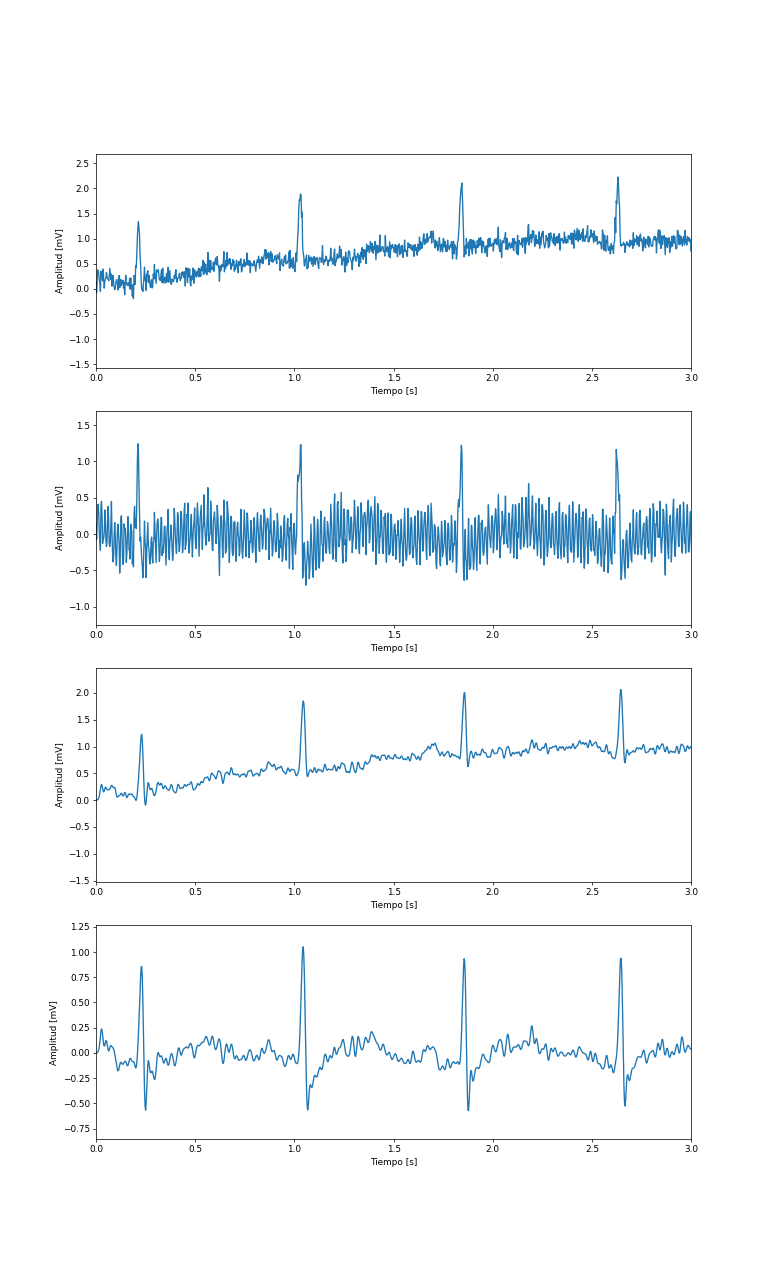

In [139]:
#Filtro_A1 = scipy.signal.iirfilter(n,Wn=[],btype="",ftype="butter",fs=Fs,output="ba")
#Wn limites de corte 
#ptype tipo de filtro 

Filtro_A1_B ,Filtro_A1_A= scipy.signal.iirfilter(n,Wn=[58,62],btype="bandstop",ftype="butter",fs=Fs,output="ba")
SinFiltroA1 = scipy.signal.lfilter(Filtro_A1_B ,Filtro_A1_A,data)

fig, ax = plt.subplots(4, 1, figsize=(12, 20), dpi=80)
ax[0].plot(time, SinFiltroA1)
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Amplitud [mV]')

Filtro_B1_B ,Filtro_B1_A= scipy.signal.iirfilter(n,Wn=0.8,btype="highpass",ftype="butter",fs=Fs,output="ba")
SinFiltroB1 = scipy.signal.lfilter(Filtro_B1_B ,Filtro_B1_A,data)
ax[1].plot(time, SinFiltroB1)
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud [mV]')

Filtro_C1_B ,Filtro_C1_A= scipy.signal.iirfilter(n,Wn=[40],btype="lowpass",ftype="butter",fs=Fs,output="ba")
SinFiltroB1 = scipy.signal.lfilter(Filtro_C1_B ,Filtro_C1_A,data)
ax[2].plot(time, SinFiltroB1)
ax[2].set_xlabel('Tiempo [s]')
ax[2].set_ylabel('Amplitud [mV]')


FiltroABC=scipy.signal.lfilter(Filtro_A1_B ,Filtro_A1_A,data)
FiltroABC=scipy.signal.lfilter(Filtro_B1_B ,Filtro_B1_A,FiltroABC)
FiltroABC=scipy.signal.lfilter(Filtro_C1_B ,Filtro_C1_A,FiltroABC)

ax[3].plot(time, FiltroABC)
ax[3].set_xlabel('Tiempo [s]')
ax[3].set_ylabel('Amplitud [mV]')

ax[0].set_xlim(0,3)
ax[1].set_xlim(0,3)
ax[2].set_xlim(0,3)
ax[3].set_xlim(0,3);


In [140]:
from IPython.display import Audio
Audio(FiltroABC, rate=Fs)